## Synthetic statistics analysis : 

Objective : Analyze the effect of different parameters on the autocorrelation of synthetic signals

Method : 

1) High and low frequency signal are generated with 1 or several draws.

2) Each signal is filtered and demodulated.

3) The autocorrelation of the demodulated signals and their superposition is then computed.


In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

###  Signals generation

High frequency  parameters : 

1) Varying amplitude, U_high

2) Varying decorrelation timescale, T

Low frequency parameters : 

1) fixed amplitude U=1

2) Varying decorrelation timescale, T_low

For high frequency : 

1) Monochromatic (M2 and S2)

2) Superposition (M2+S2 and M2+S2+N2+K2)

Total signal is computed is a result of the superposition of high and low frequency signals.

### Filtering and demodulation : 

High frequency (monochromatic and superpositions) and total signals are band pass filtered. Two varying parameters are used : 

1) Bandwidth, $d\omega$

2) Kernel length, $T_w$


The central frequency is : 

1) M2 or S2 for the monochromatic signals

2) (M2+S2)/2 for the superpositions (high frequency and total signals)

In [3]:
#Load data
path = '/Users/zcaspar/codes/mit4320/' 
ds1 = xr.open_dataset(path+'synthetic_1.nc') #one draw
ds30 = xr.open_dataset(path+'synthetic_30.nc') #30 draws
ds78 = xr.open_dataset(path+'synthetic_78.nc') # 78 draws

#### Impact of amplitude, decorrelation timescale, kernel length and bandwidth on monochromatic signal, M2

We can expect problems if : 

1) Inverse bandwidth is small compared to kernel length : $1/d\omega \leq T_w$

2) Inverse bandwidth is small compared to decorrelation timescale : $1/d\omega \leq T$

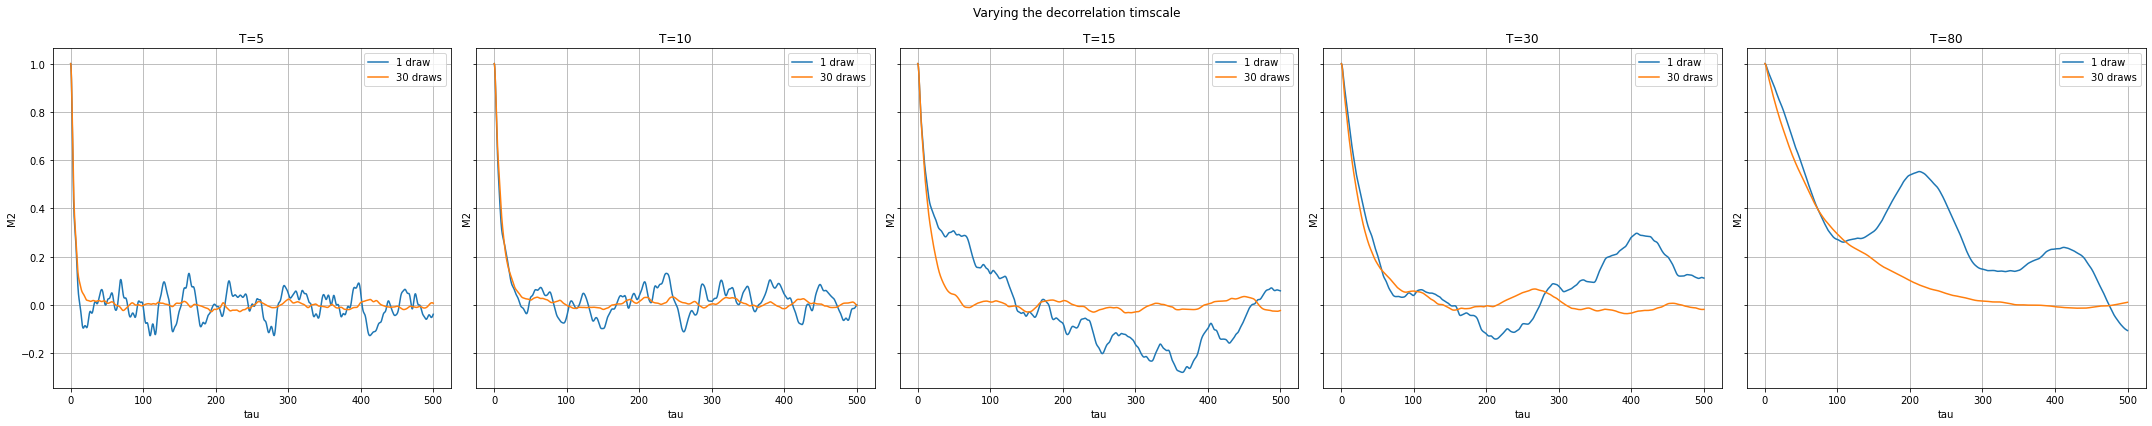

In [19]:
fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*ds1.T.size,6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw')
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=15).plot(ax=ax[i],label='30 draws')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timscale');
fig.tight_layout();

Notes on varying decorrelation timescale : 

Small oscillations are observed, superposed to the 'general' form. They are dampened when averaging over 30 draws.

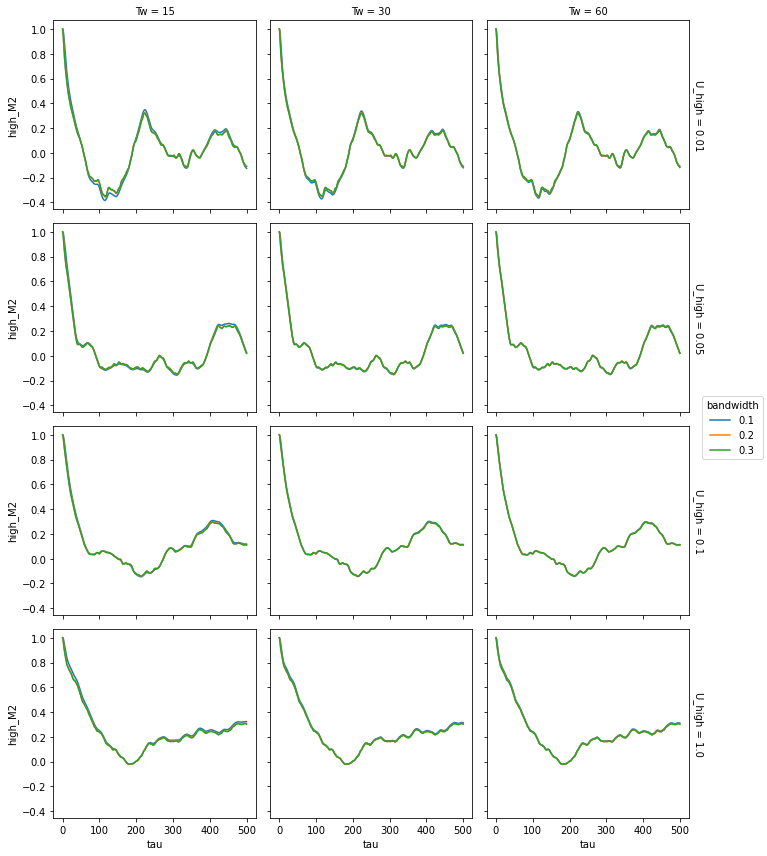

In [20]:
(ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(T=30).plot(hue='bandwidth',row='U_high',col='Tw')

Notes on varying amplitude, kernal length and bandwidth : 

1) Amplitude : modifies the form

2) Small changes between different bandwidth for $T_w=15days$

3) Small impact of kernel length on the impact of the bandwidth (but we are not in the case where $1/d\omega \leq T_w$)



<Figure size 432x288 with 0 Axes>

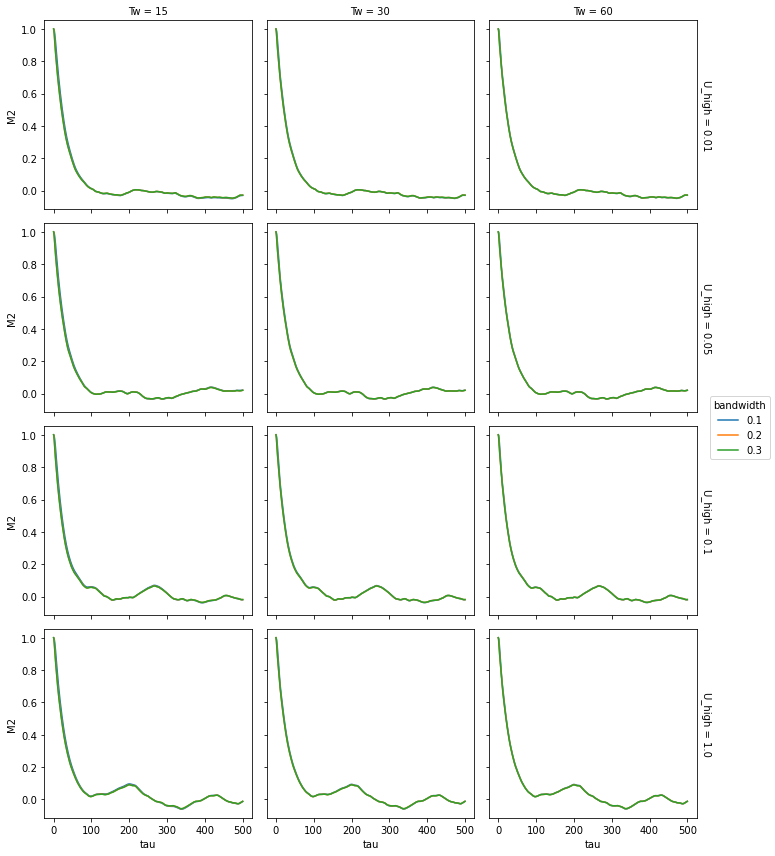

In [21]:
plt.figure()
(ds30.M2/ds30.M2.isel(tau=0)).sel(T=30,T_low=5).plot(hue='bandwidth',row='U_high',col='Tw')

Notes on averaging : 

1) Averaging remove the effects of bandwidth and kernel length.

2) Amplitude effect is also dampened

#### High frequency signal (M2+S2)

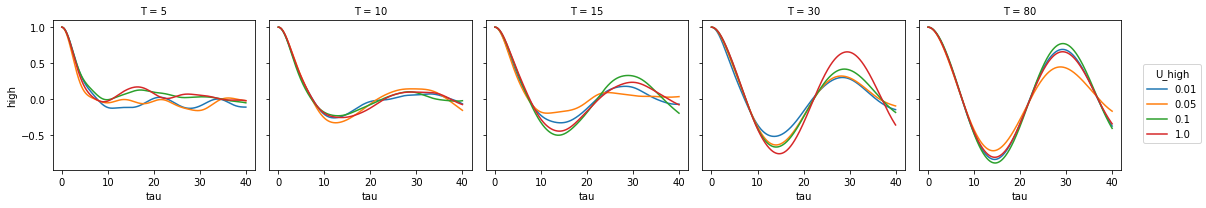

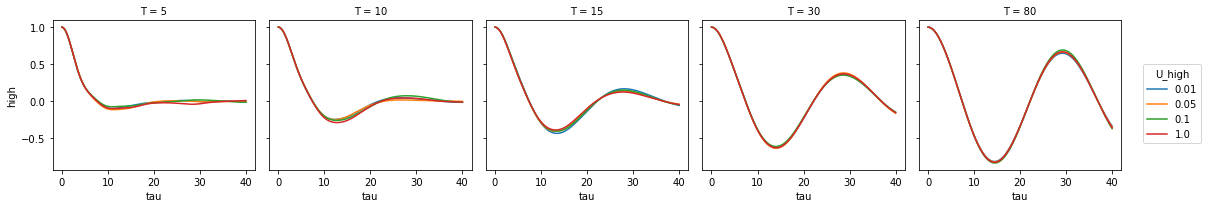

In [30]:
(ds1.high/ds1.high.isel(tau=0)).sel(bandwidth=0.2,Tw=30).sel(tau=slice(0,40)).plot(hue='U_high',col='T')
(ds30.high/ds30.high.isel(tau=0)).sel(bandwidth=0.2,Tw=30,T_low=15).sel(tau=slice(0,40)).plot(hue='U_high',col='T')



#plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()
    

Notes on decorrelation timescale and amplitude : 

1) Spring neap cycle for $T \geq 15 days$

2) Negative lobe around 10 days for T=5,10 days

3) Amplitude modifies form for 1 draw; impact removed by averaging

NB : Here one possible explanation for oscillations of period shorter than spring neap cycle is decorrelation timescale too small compared to the cycle, no significant impact of bandwidth, etc in the observed cases (we did not test very small kernel size that could introduce new problems). 

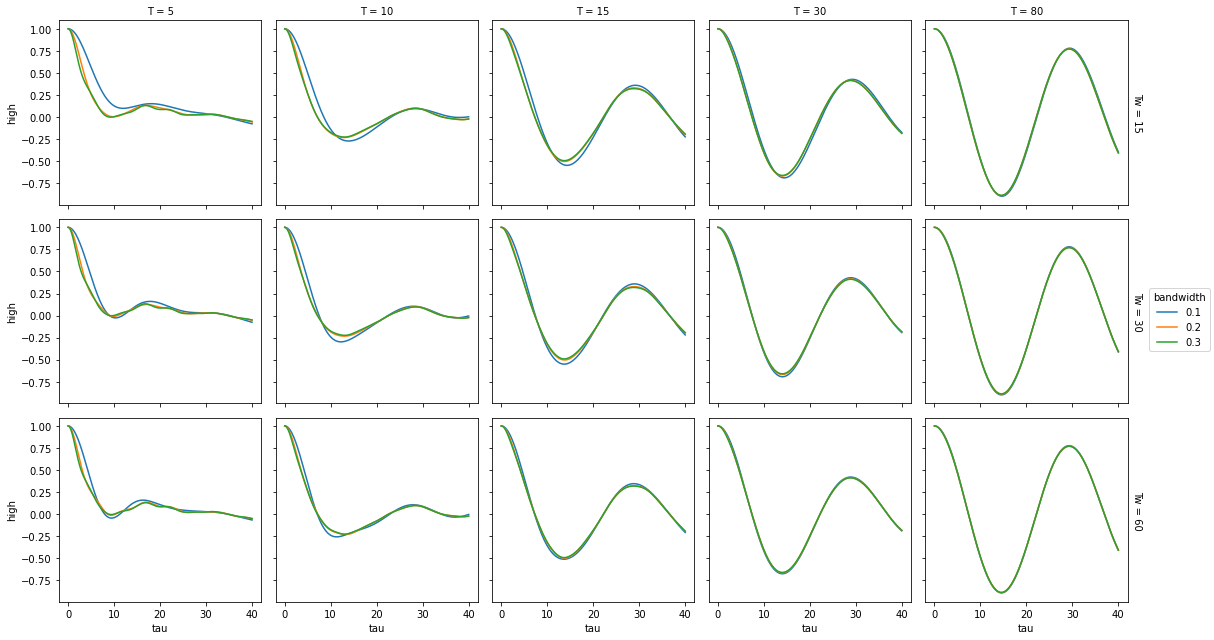

In [37]:
(ds1.high/ds1.high.isel(tau=0)).sel(U_high=0.1).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) For $T \leq 15d$ : effect of bandwidth (smoother for smallest)

2) Kernel length reduces variability due to bandwidth

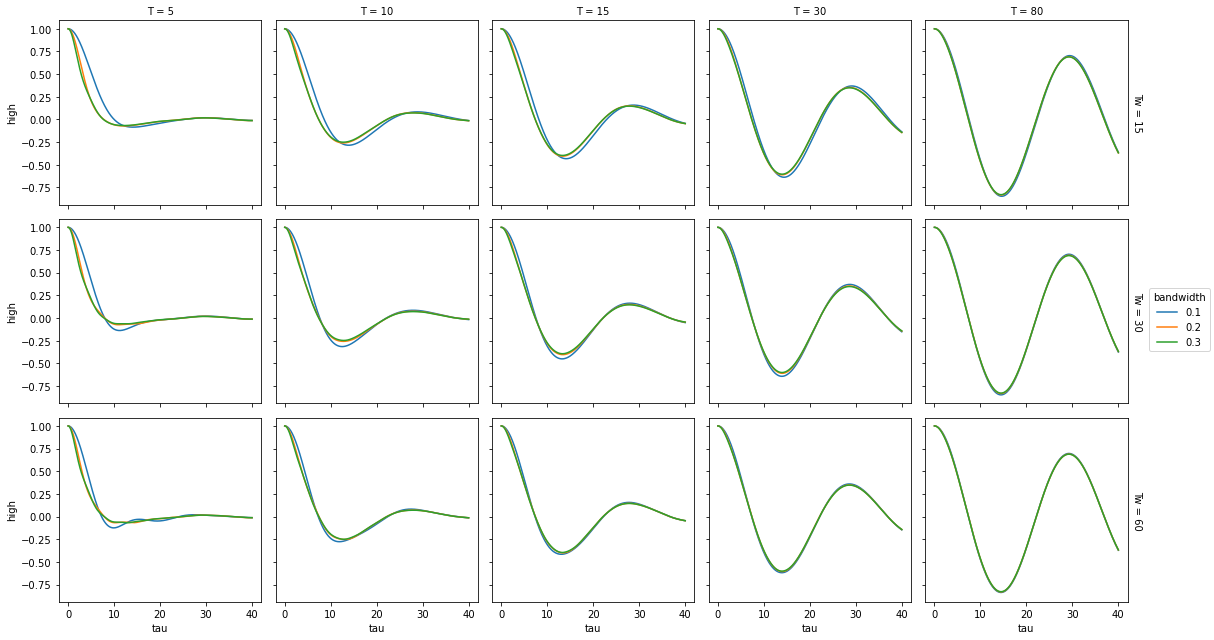

In [40]:
(ds30.high/ds30.high.isel(tau=0)).sel(U_high=0.1,T_low=15).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) Averaging dampens oscillations for T=5 (as for monochromatic)

2) Variability due to bandwidth and kernel length

3) Negative lobe for T=10 days and for T=5days and $d\omega=0.1$

#### Low frequency

In [63]:
ds30

<xarray.Dataset>
Dimensions:    (T: 5, T_low: 3, Tw: 3, U_high: 4, bandwidth: 3, tau: 12000)
Coordinates:
  * T          (T) int64 5 10 15 30 80
  * U_high     (U_high) float64 0.01 0.05 0.1 1.0
  * T_low      (T_low) int64 5 15 30
  * Tw         (Tw) int64 15 30 60
  * bandwidth  (bandwidth) float64 0.1 0.2 0.3
  * tau        (tau) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
Data variables:
    M2         (Tw, bandwidth, T, U_high, T_low, tau) float64 ...
    S2         (Tw, bandwidth, T, U_high, T_low, tau) float64 ...
    high       (Tw, bandwidth, T, U_high, T_low, tau) float64 ...
    total      (Tw, bandwidth, T, U_high, T_low, tau) float64 ...

In [61]:
(ds1.low/ds1.low.isel(tau=0)).sel(T_low=15).sel(tau=slice(0,40)).plot()
(ds30.low/ds30.low.isel(tau=0)).sel(T_low=15).sel(tau=slice(0,40)).plot()

AttributeError: 'Dataset' object has no attribute 'low'

#### Total

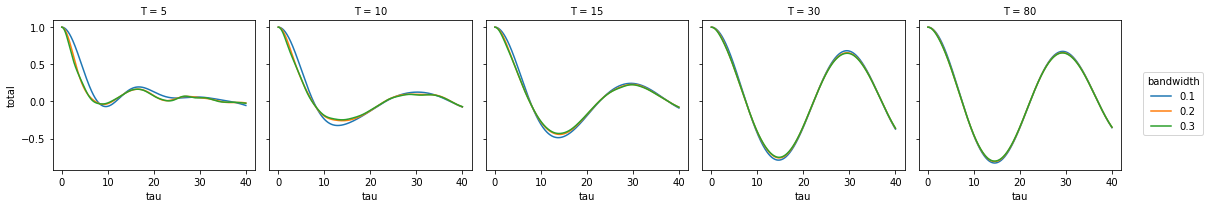

In [42]:
(ds1.total/ds1.total.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T')

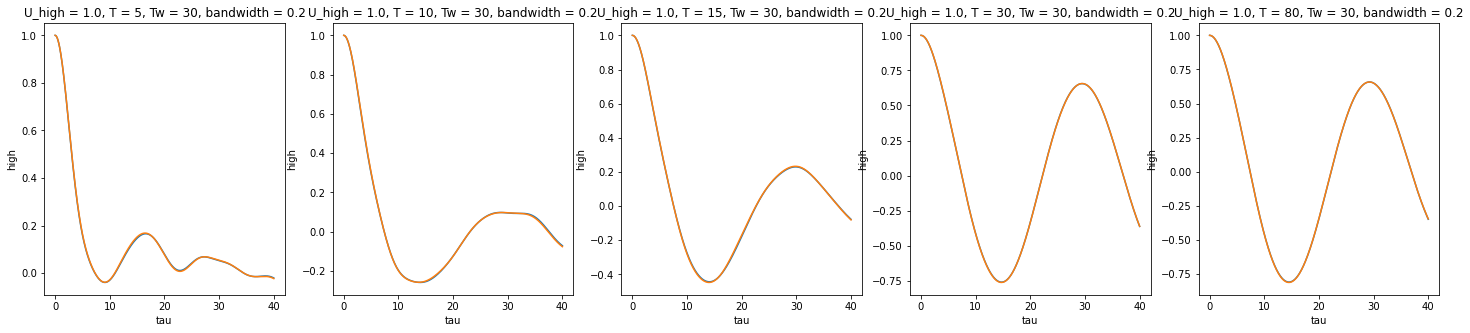

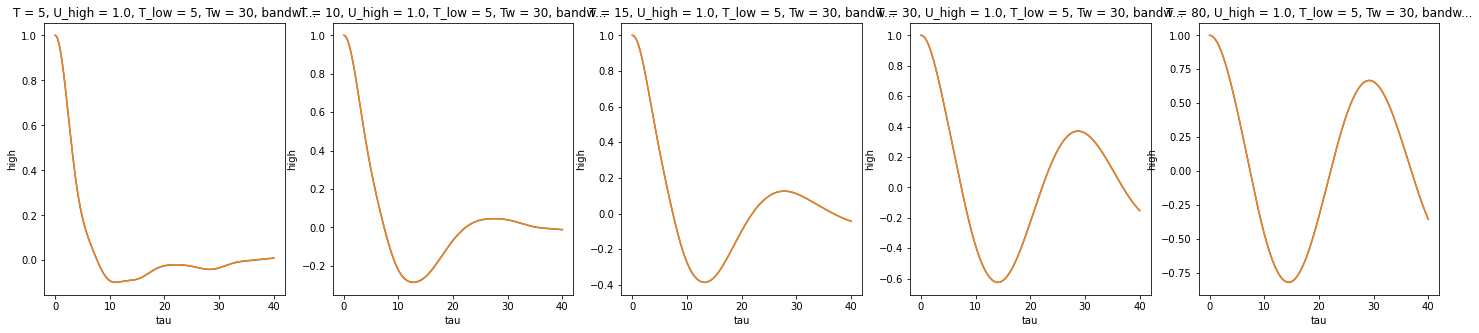

In [55]:
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds1.high/ds1.high.isel(tau=0)).sel(U_high=1.,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds30.high/ds30.high.isel(tau=0)).sel(U_high=1.,T_low=5,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])

Notes : 

If U_high = U, there is no differences between high frequency and total signal. No impact of the low singal on the final result.

#### U_high= U/10 and T_low=5days

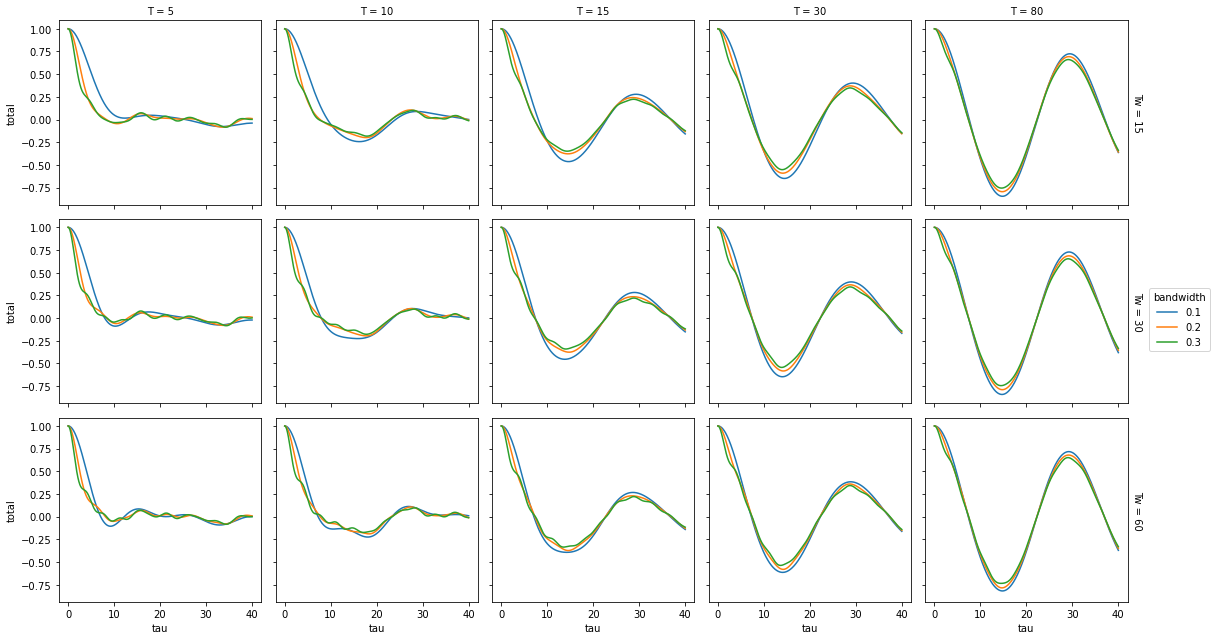

In [49]:
(ds1.total/ds1.total.isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) Larger impact of bandwidth for all values of T

2) $d\omega$=0.2 cpd has very smooth results (leakage??)

3) Small oscillations increases when T decreases and bandwidth increases.

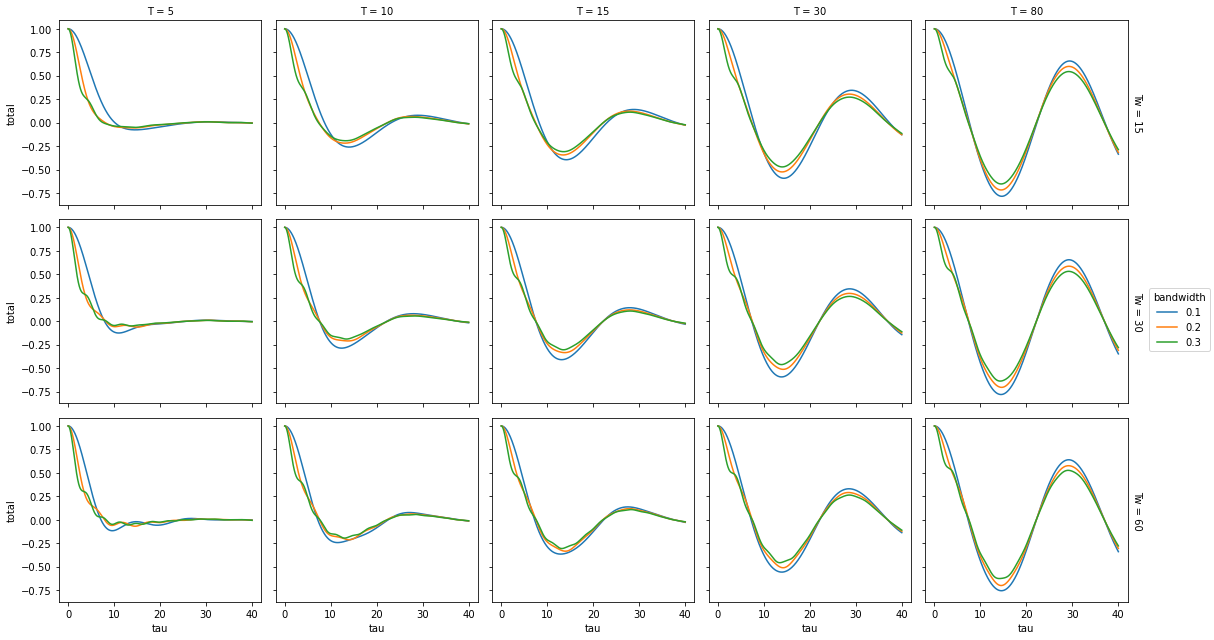

In [50]:
(ds30.total/ds30.total.isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) Averaging dampens small oscillations but still there for $d\omega$=0.6 cpd

2) Negative lobe still there for T=5,10 days ; increased for $d\omega$=0.2 cpd

#### U_high= U/10 and T_low=30days

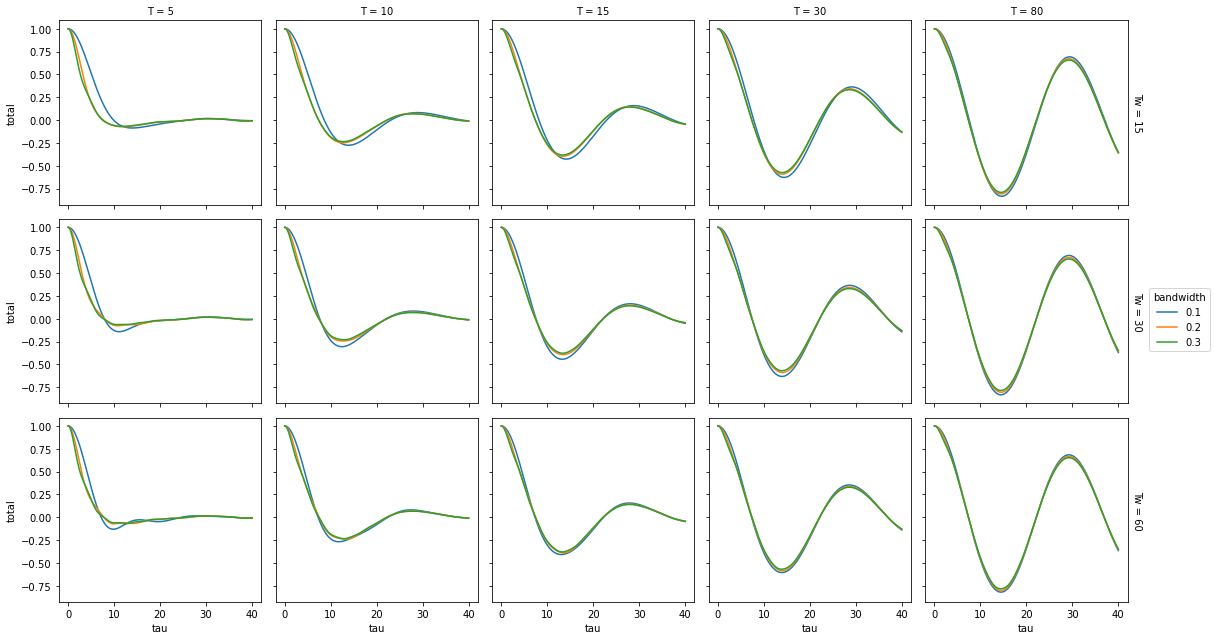

In [51]:
(ds30.total/ds30.total.isel(tau=0)).sel(U_high=0.1,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

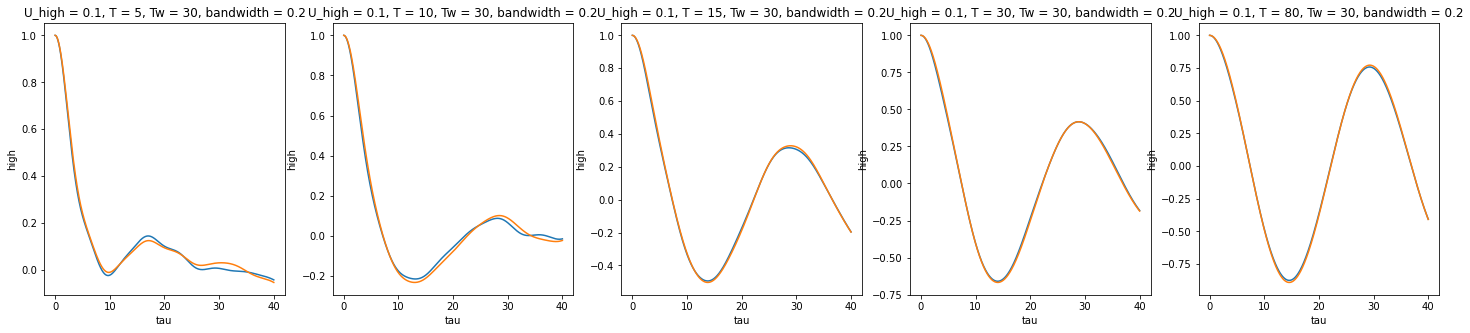

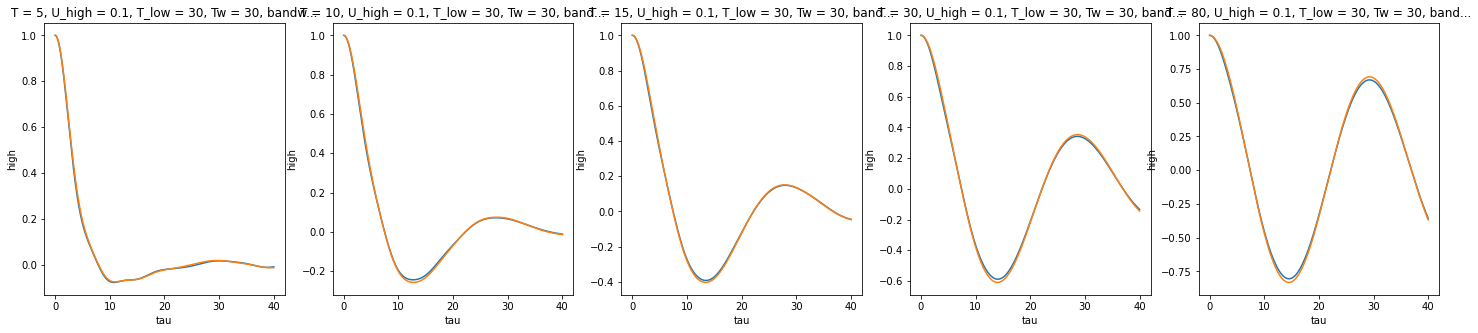

In [53]:
U = 0.1
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=30,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds1.high/ds1.high.isel(tau=0)).sel(U_high=U,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=30,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds30.high/ds30.high.isel(tau=0)).sel(U_high=U,T_low=30,Tw=30,bandwidth=0.2,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])

Notes : Small differences between total and high frequency signal but overall it is similar (very similar for the average).

#### U_high=U/100 and T_low=5 days

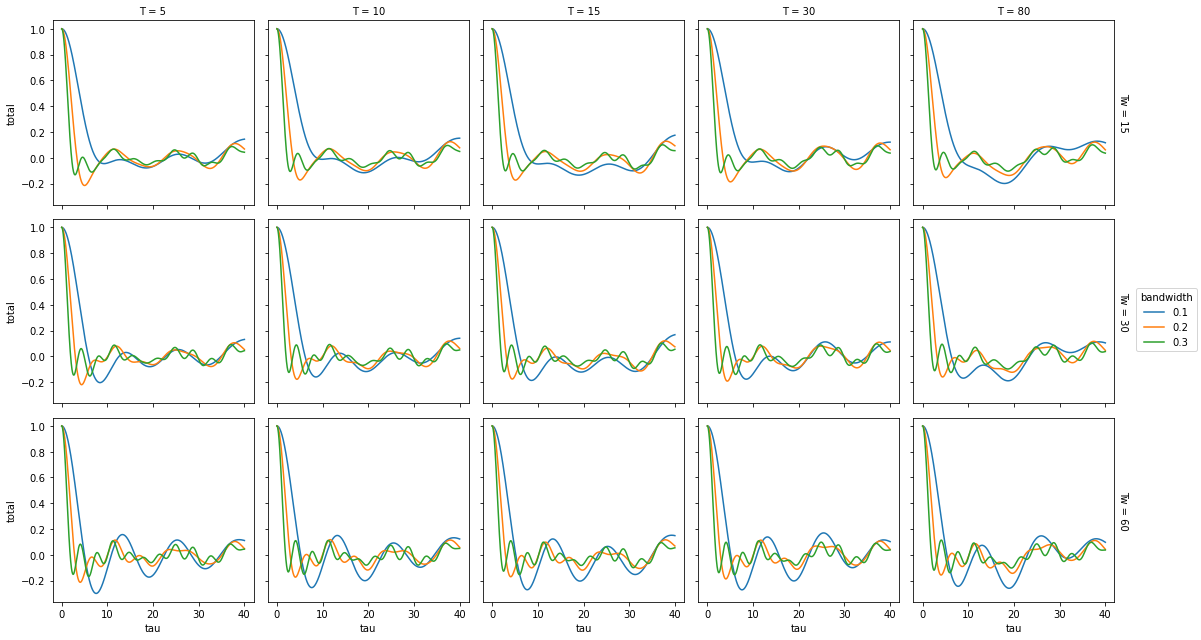

In [56]:
(ds1.total/ds1.total.isel(tau=0)).sel(U_high=0.01,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) No spring neap cycle

2) Small oscillations for all values of T

3) Effect of the kernel length

4) $d\omega=0.1$ still a lot smoother

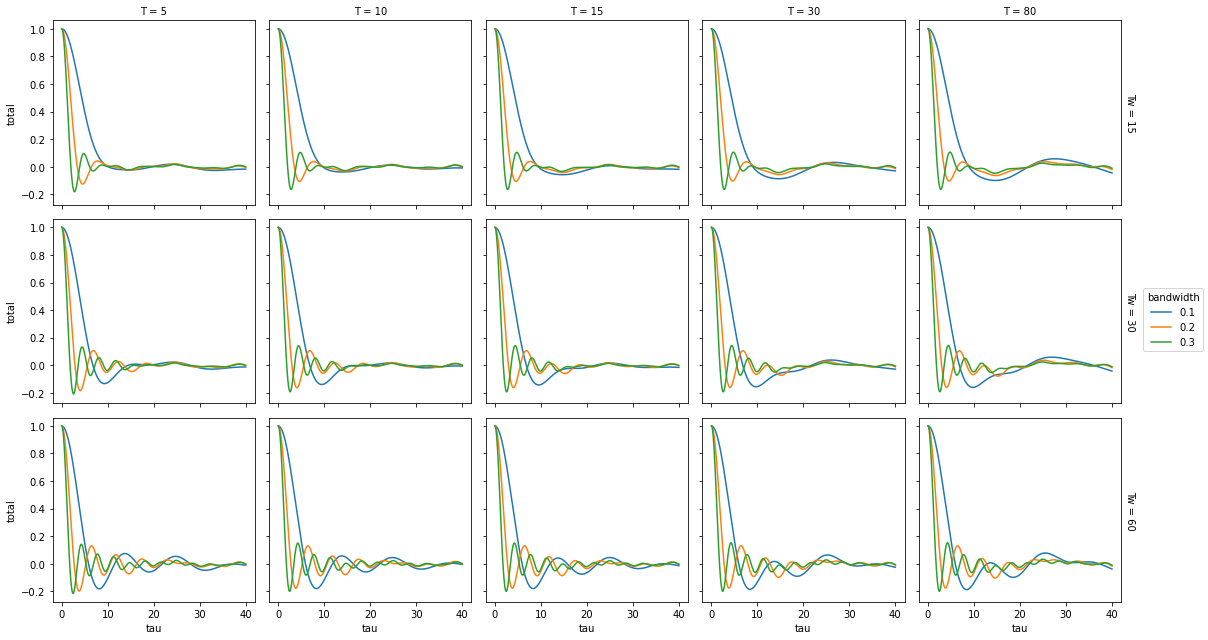

In [58]:
(ds30.total/ds30.total.isel(tau=0)).sel(U_high=0.01,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

This time averaging does not dampen the oscillations, in the contrary they seem more robust.

Oscillations are more robuts depending on tau when the kernel length increases.

Still no spring neap cycle

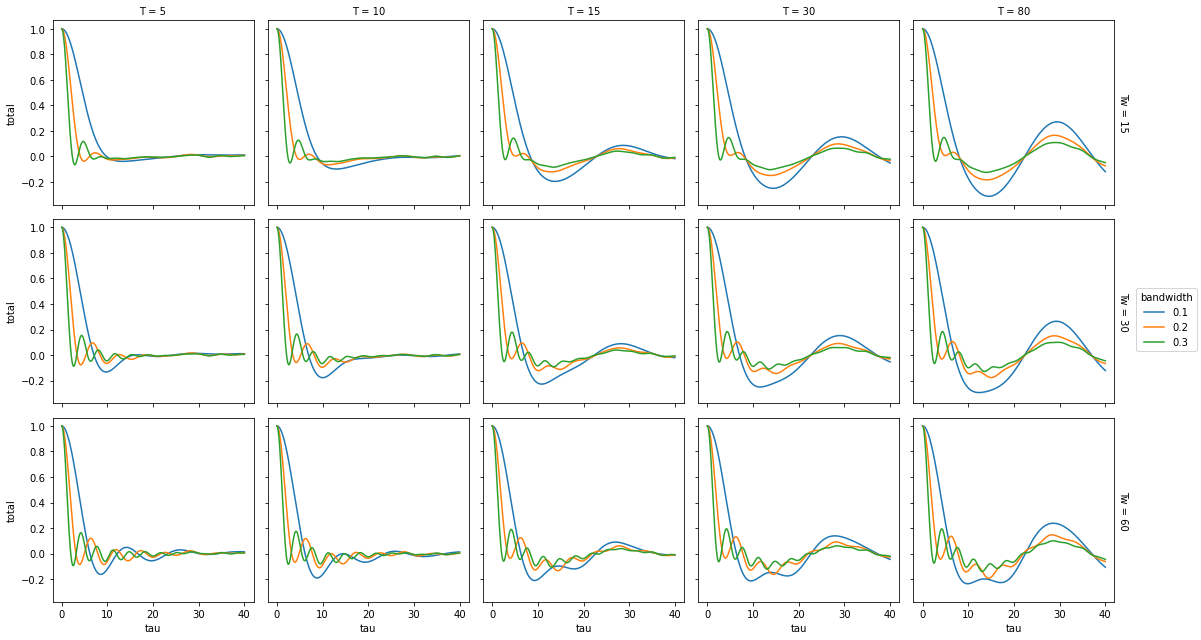

In [60]:
(ds30.total/ds30.total.isel(tau=0)).sel(U_high=0.01,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')

Notes : 

1) Spring neap cycle for $T\geq 30 days$

2) Small oscillations for $d\omega=0.4,0.6$

<Figure size 432x288 with 0 Axes>

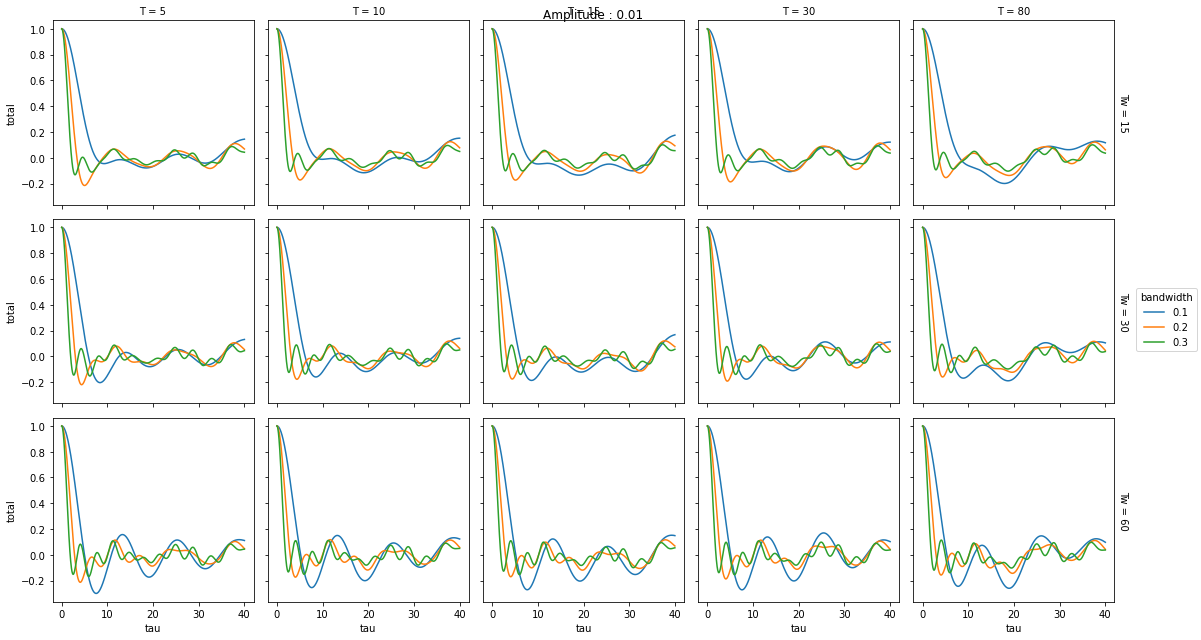

<Figure size 432x288 with 0 Axes>

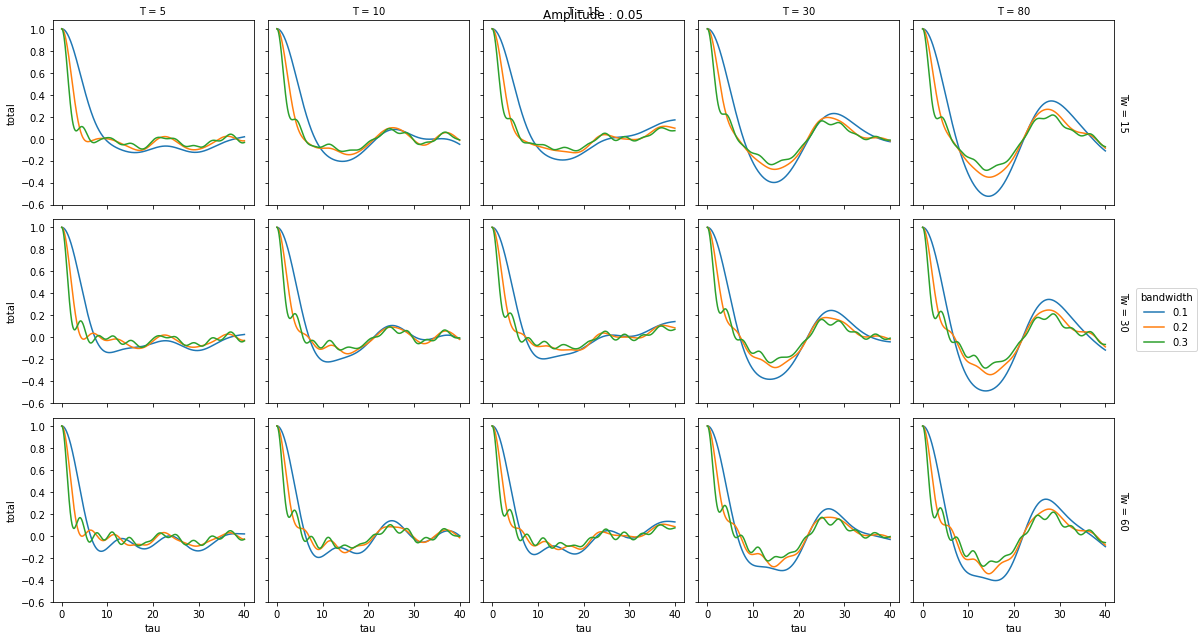

<Figure size 432x288 with 0 Axes>

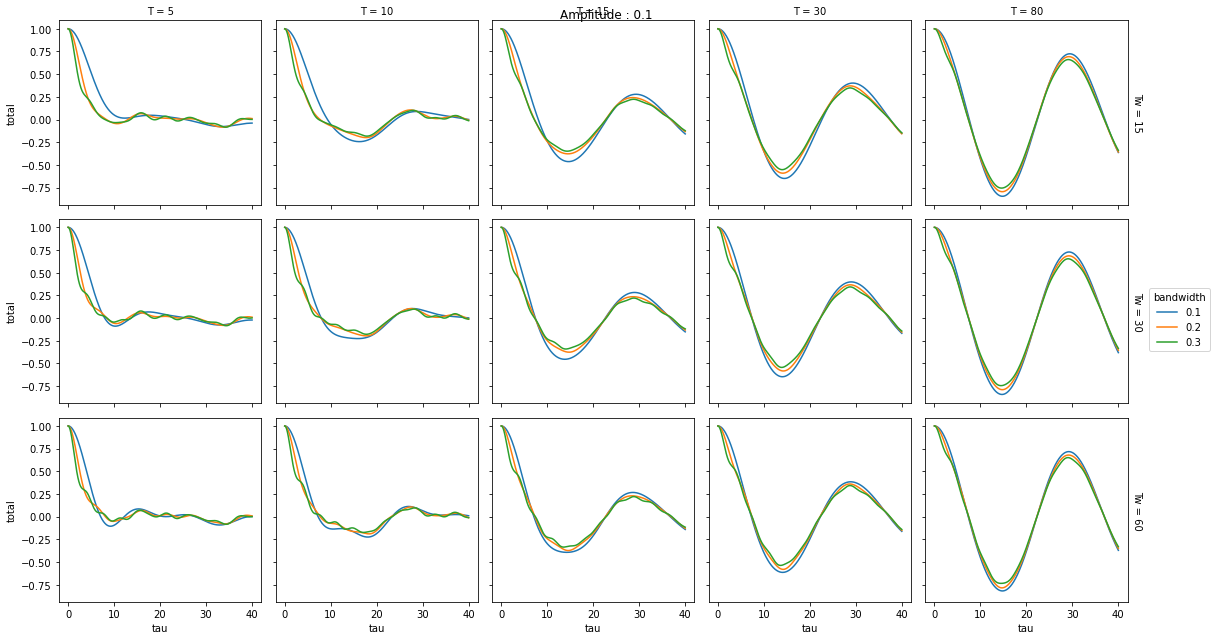

<Figure size 432x288 with 0 Axes>

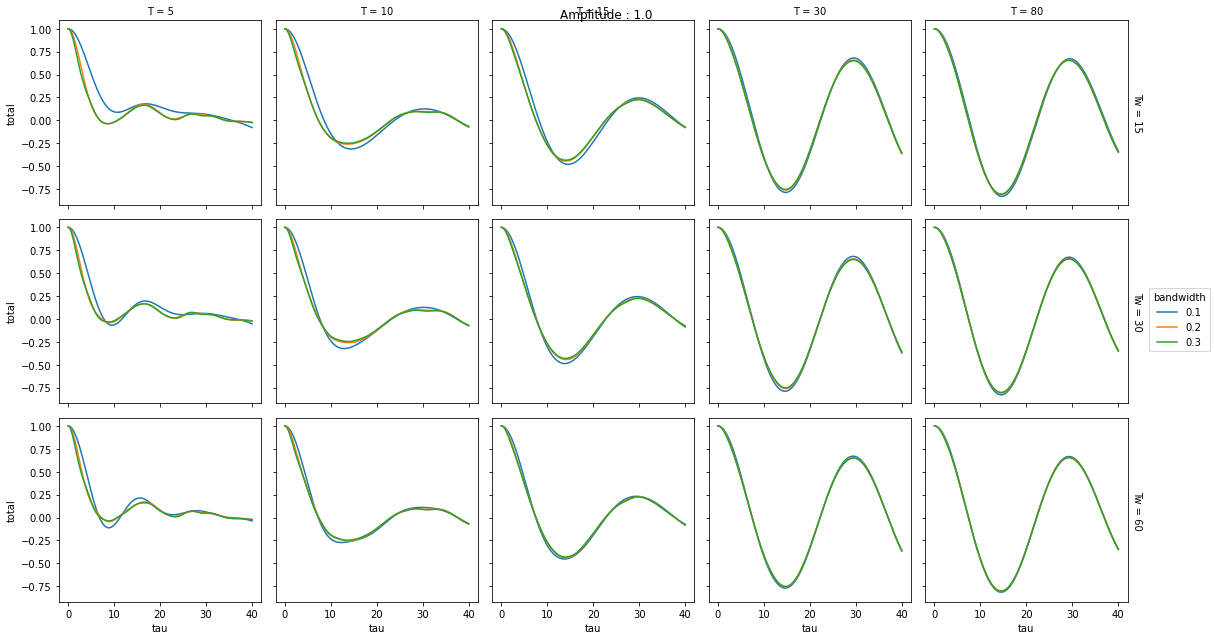

In [41]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

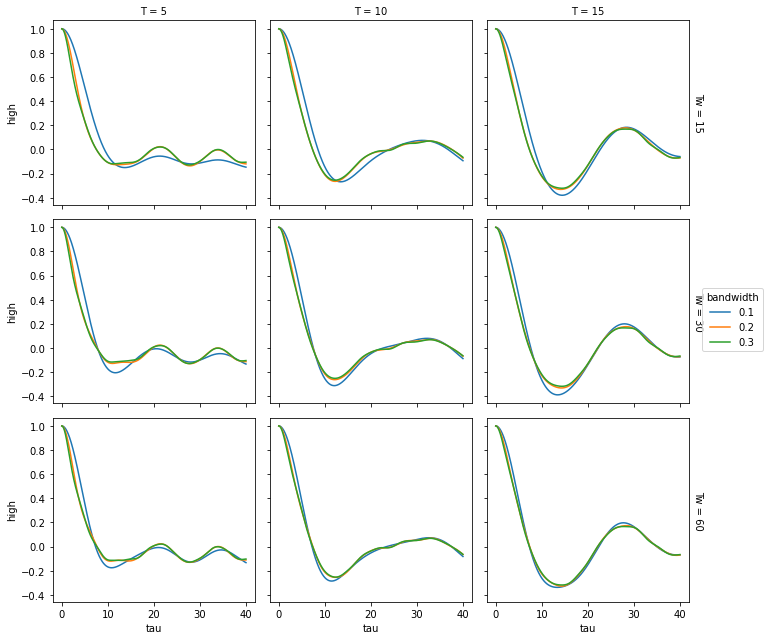

<Figure size 432x288 with 0 Axes>

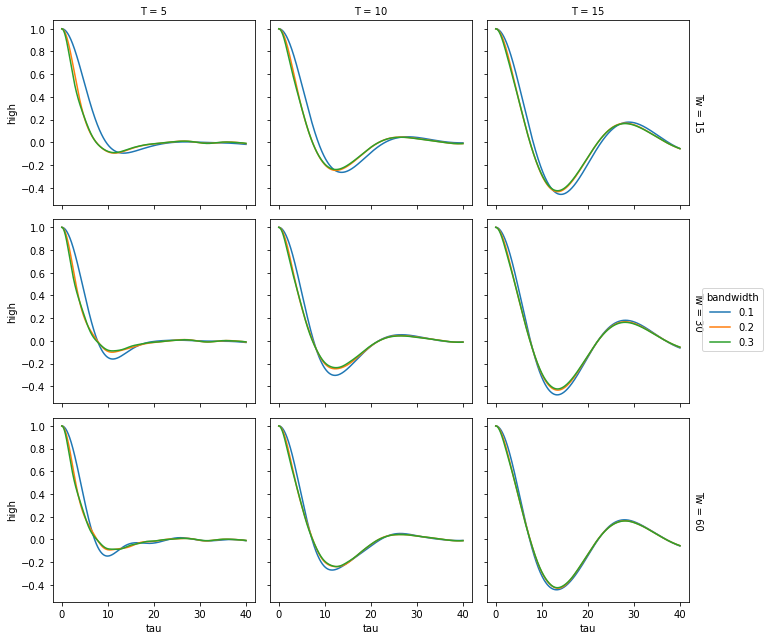

<Figure size 432x288 with 0 Axes>

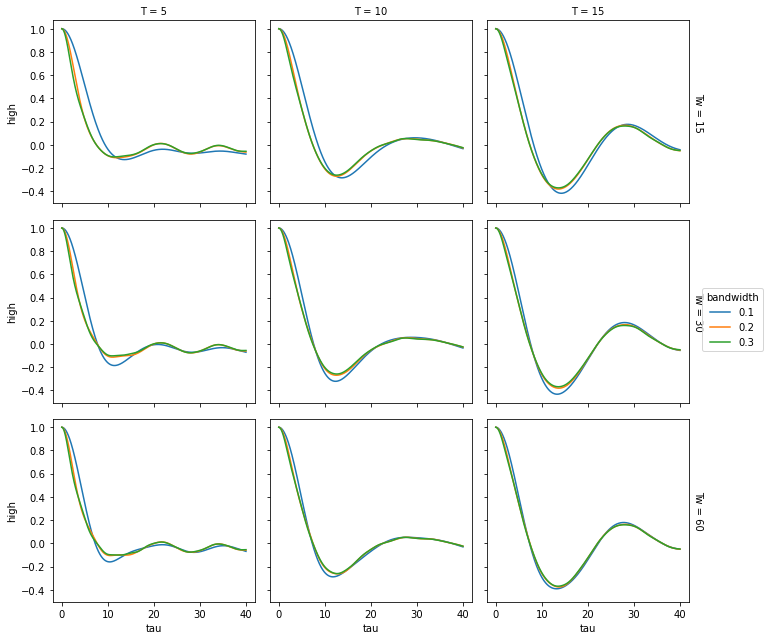

In [51]:
fig = plt.figure()
(ds1.high/ds1.high.isel(tau=0)).sel(U_high=.01).sel(tau=slice(0,40),T=slice(5,15)).plot(hue='bandwidth',col='T',row='Tw')
fig.tight_layout()
fig = plt.figure()
(ds30.high/ds30.high.isel(tau=0)).sel(U_high=.01,T_low=5).sel(tau=slice(0,40),T=slice(5,15)).plot(hue='bandwidth',col='T',row='Tw')
fig.tight_layout()
fig = plt.figure()
(ds78.high/ds78.high.isel(tau=0)).sel(U_high=.01,T_low=5).sel(tau=slice(0,40),T=slice(5,15)).plot(hue='bandwidth',col='T',row='Tw')
fig.tight_layout()

#### Estimation timescales:

In [90]:
tf=10
T1_high = ((ds1.high/ds1.high.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T30_high = ((ds30.high/ds30.high.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T78_high  = ((ds78.high/ds78.high.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')


T1 = ((ds1.total/ds1.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T30 = ((ds30.total/ds30.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')
T78  = ((ds78.total/ds78.total.sel(tau=0))**2).sel(tau=slice(0,tf)).sum('tau')

In [91]:
Tt_high = xr.Dataset({'T1':T1_high,'T30':T30_high,'T78':T78_high})
Tt = xr.Dataset({'T1':T1,'T30':T30,'T78':T78})

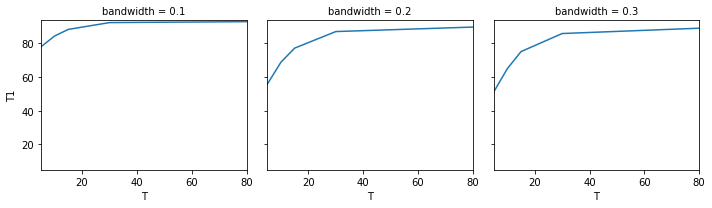

<Figure size 432x288 with 0 Axes>

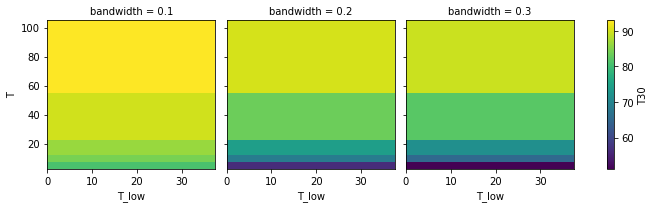

<Figure size 432x288 with 0 Axes>

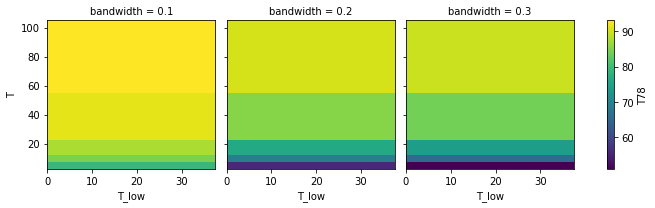

In [92]:
Tt_high.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
plt.figure()
Tt_high.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

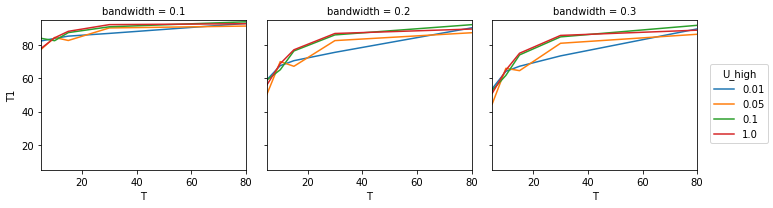

<Figure size 432x288 with 0 Axes>

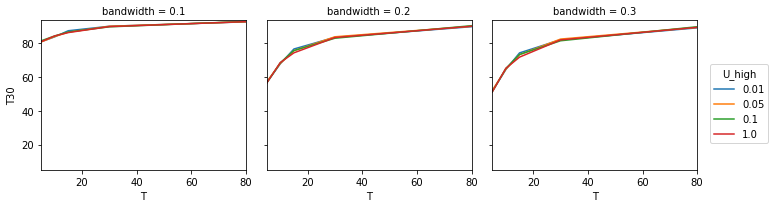

<Figure size 432x288 with 0 Axes>

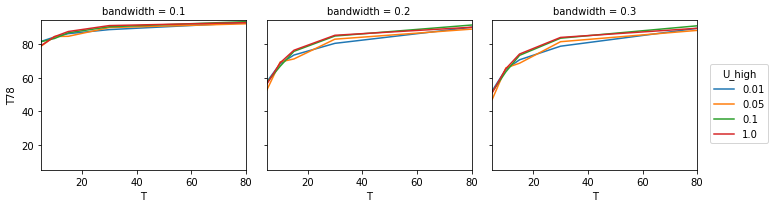

In [95]:
Tt_high.T1.sel(Tw=30).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T78.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None))

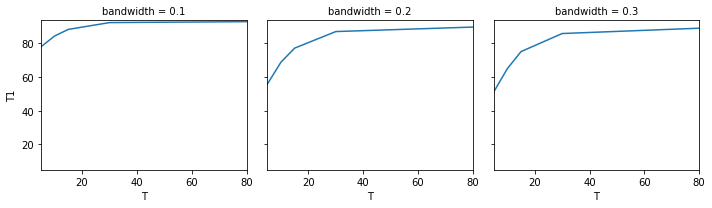

<Figure size 432x288 with 0 Axes>

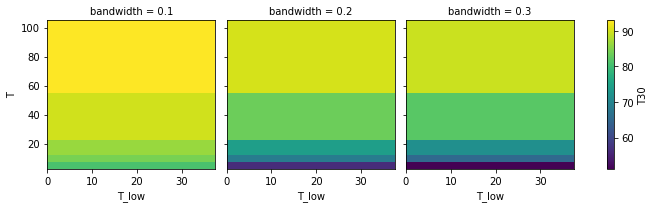

<Figure size 432x288 with 0 Axes>

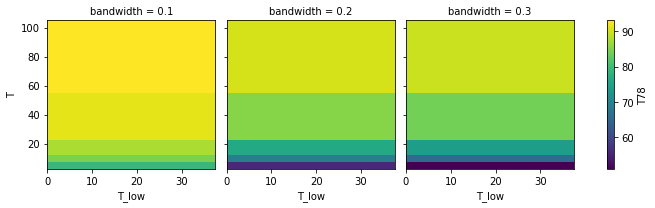

In [96]:
Tt_high.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth',xlim=(5,80),ylim=(5,None))
plt.figure()
Tt_high.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
plt.figure()
Tt_high.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

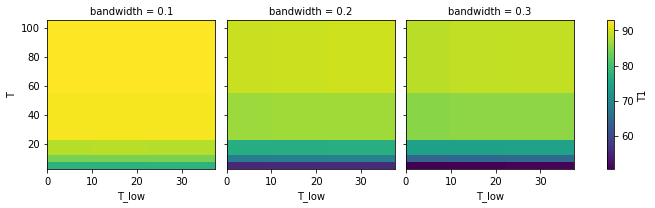

<Figure size 432x288 with 0 Axes>

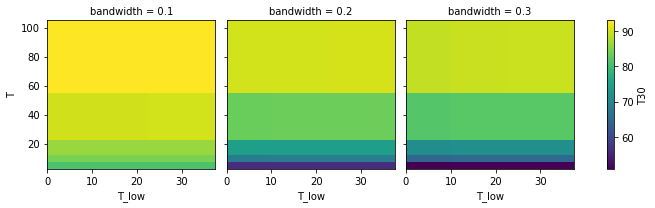

<Figure size 432x288 with 0 Axes>

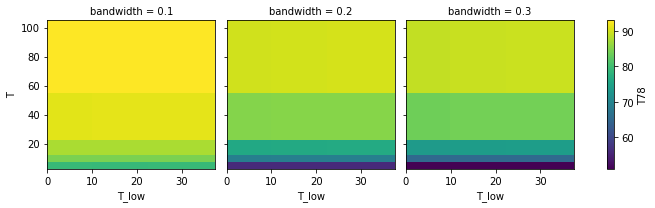

In [97]:
Tt.T1.sel(U_high=1.,Tw=30).plot(col='bandwidth')
plt.figure()
Tt.T30.sel(U_high=1.,Tw=30).plot(col='bandwidth')
plt.figure()
Tt.T78.sel(U_high=1.,Tw=30).plot(col='bandwidth')

Notes : 

ça marche très très peu...

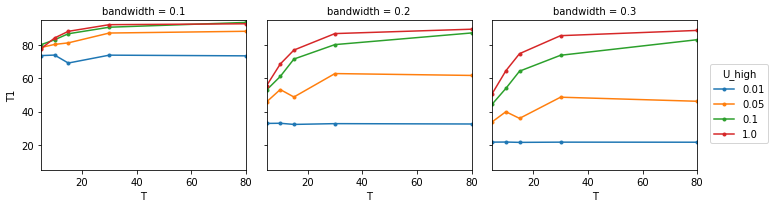

<Figure size 432x288 with 0 Axes>

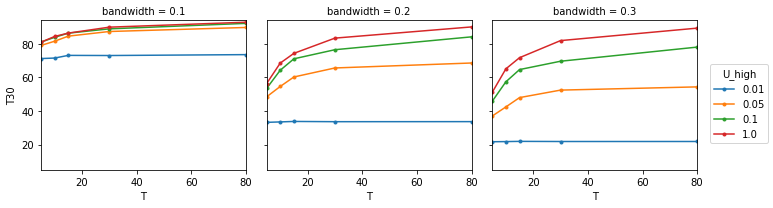

<Figure size 432x288 with 0 Axes>

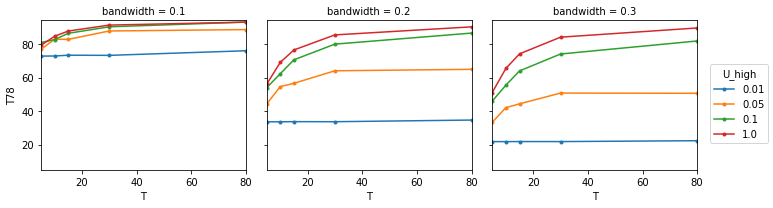

In [98]:
Tt.T1.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')
plt.figure()
Tt.T30.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')
plt.figure()
Tt.T78.sel(Tw=30,T_low=15).plot(col='bandwidth',hue='U_high',xlim=(5,80),ylim=(5,None),marker='.')

### Total signal : 

<Figure size 432x288 with 0 Axes>

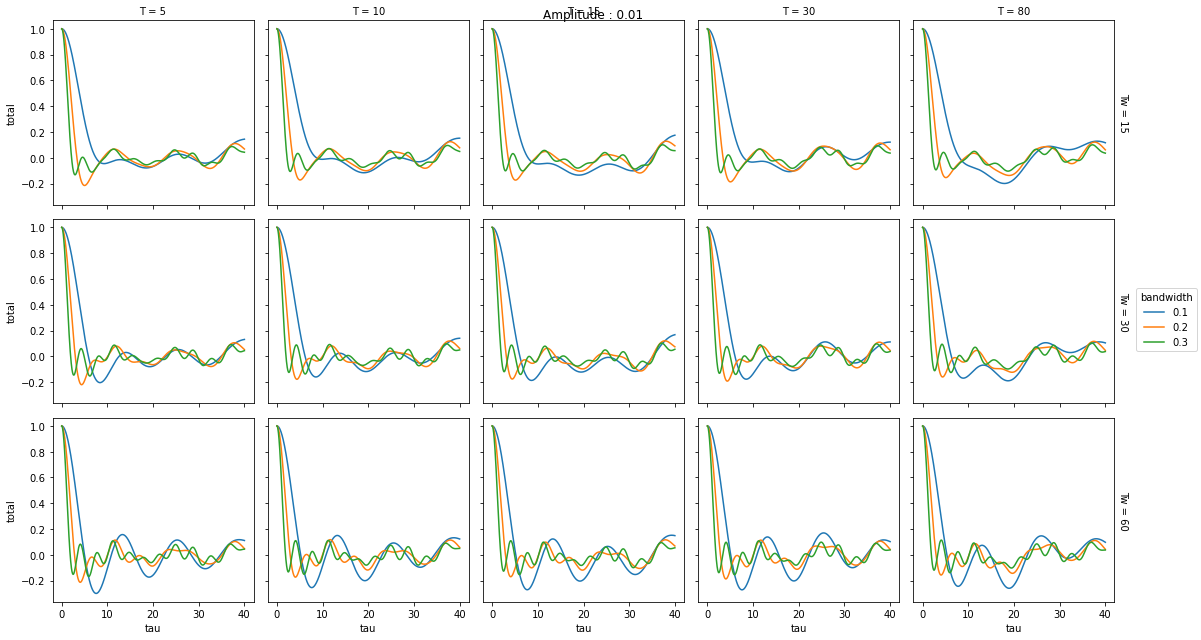

<Figure size 432x288 with 0 Axes>

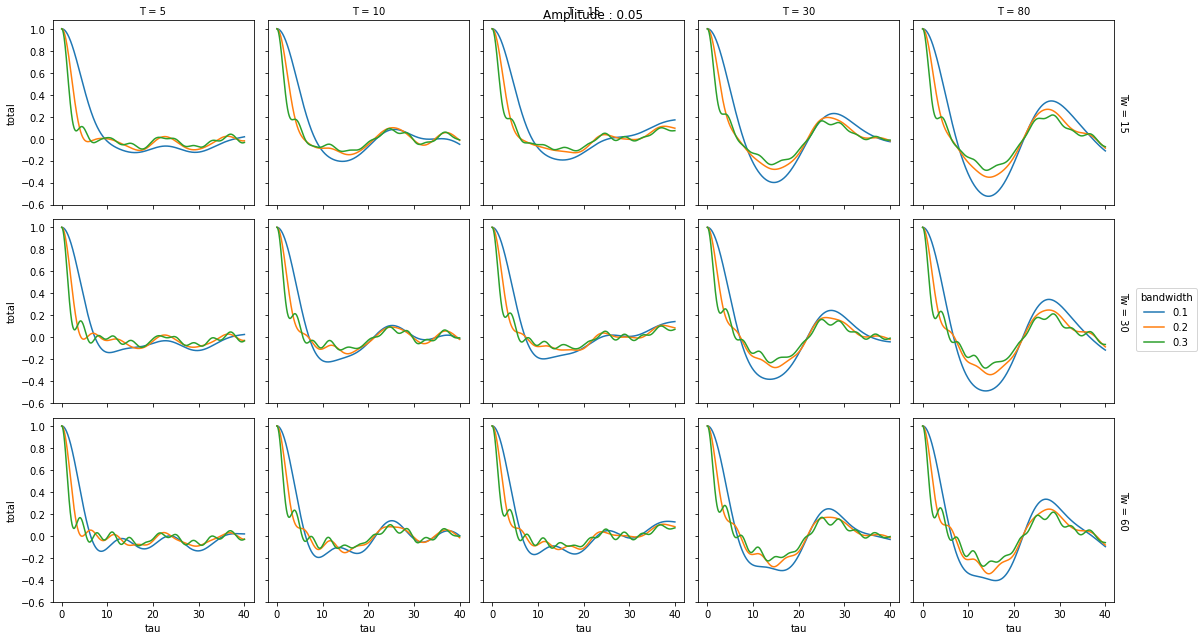

<Figure size 432x288 with 0 Axes>

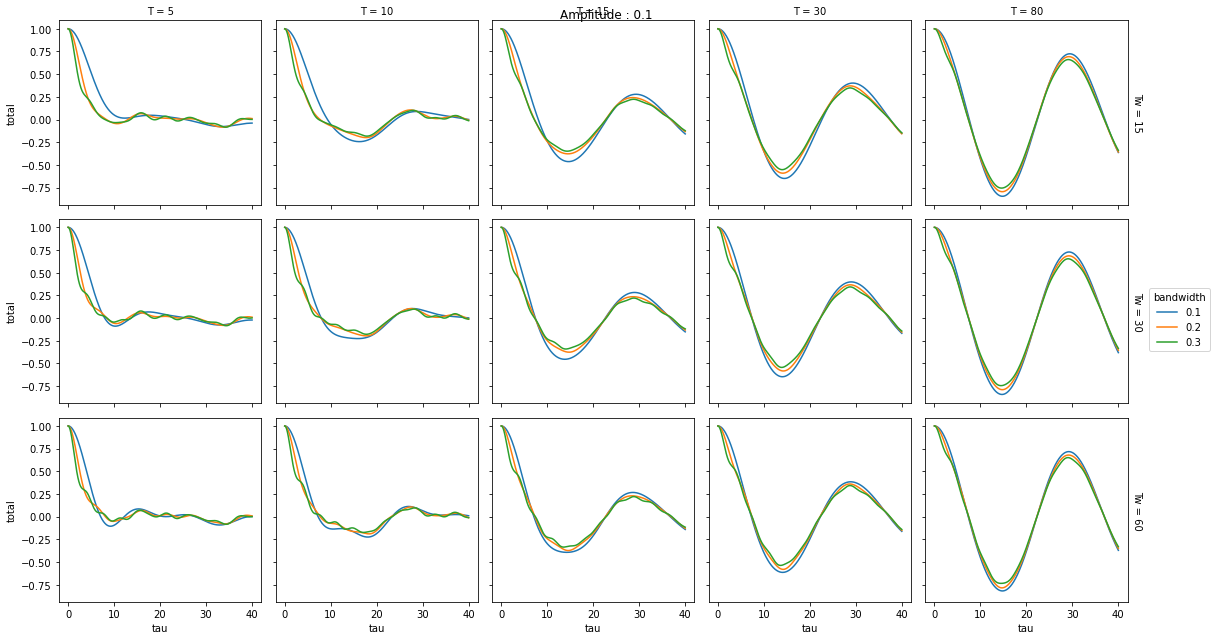

<Figure size 432x288 with 0 Axes>

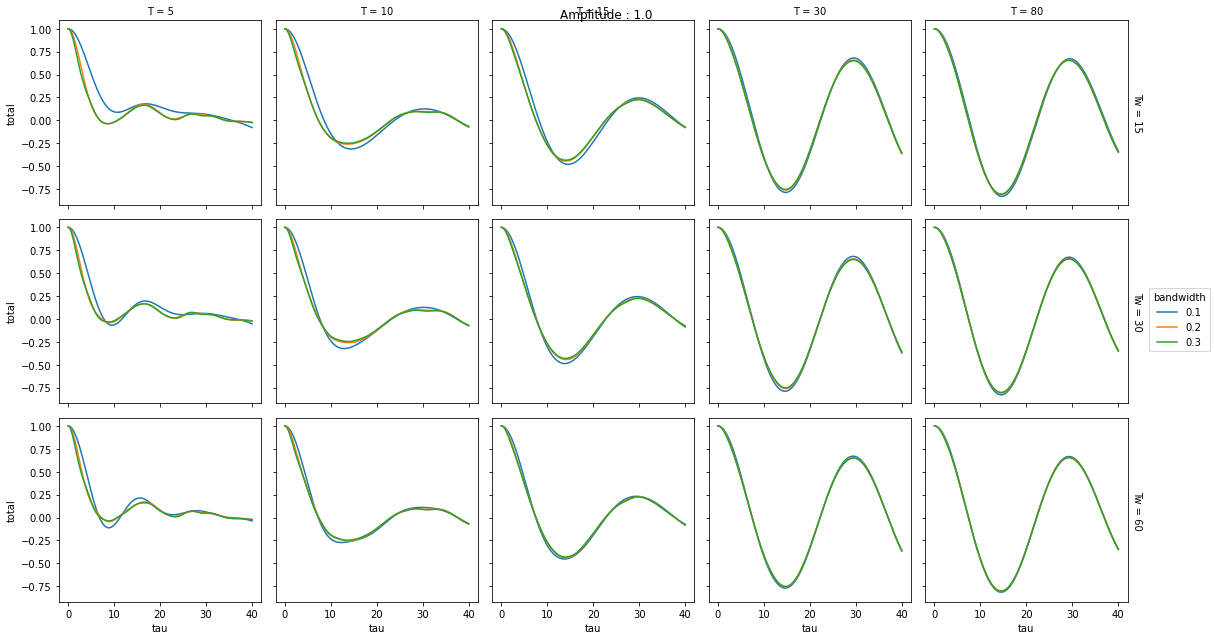

In [64]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

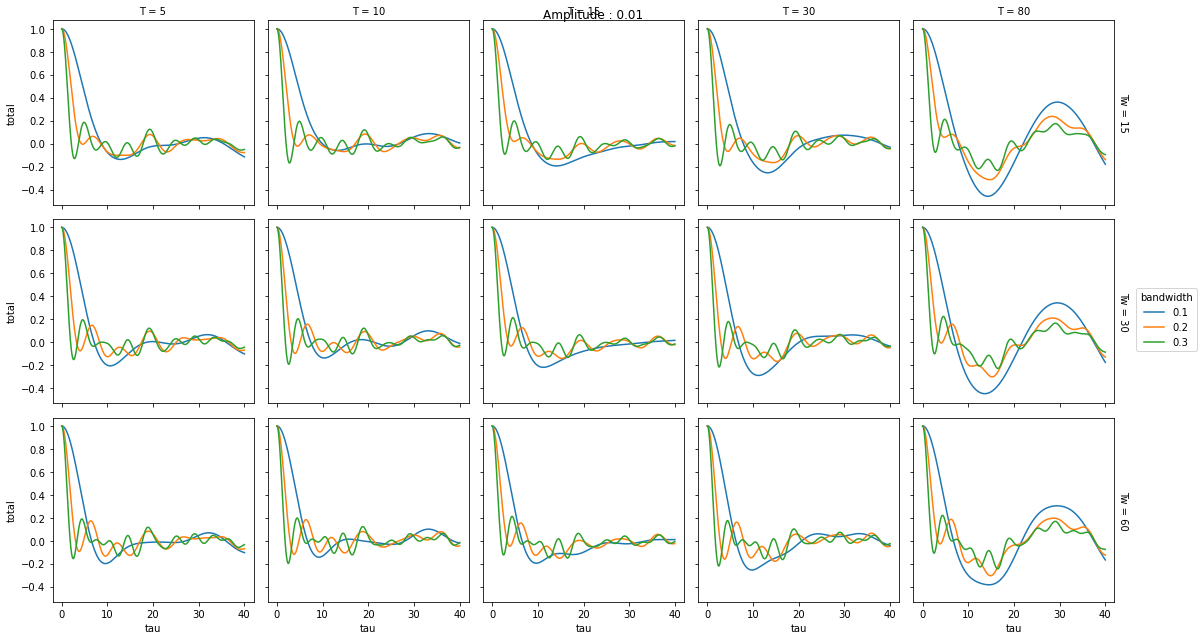

<Figure size 432x288 with 0 Axes>

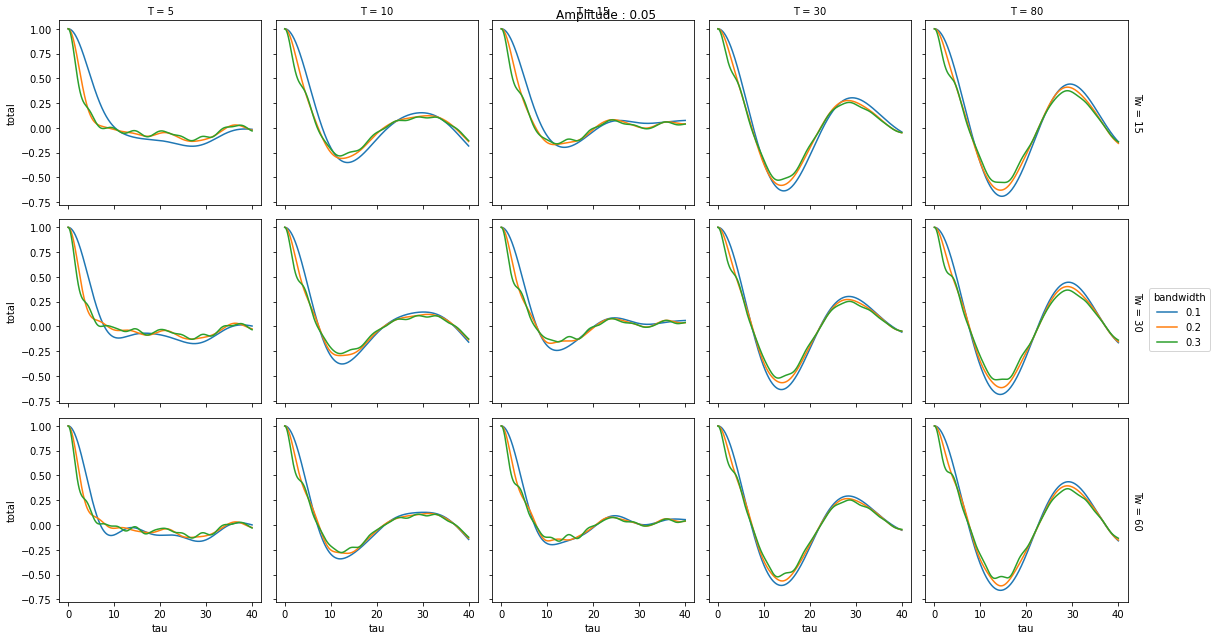

<Figure size 432x288 with 0 Axes>

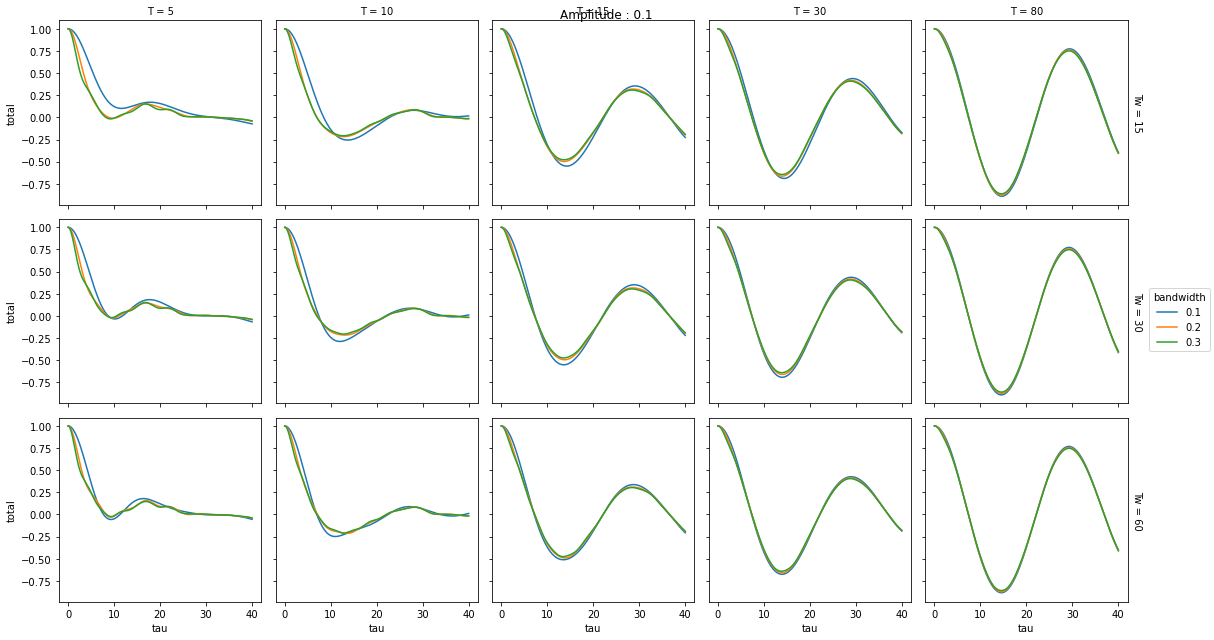

<Figure size 432x288 with 0 Axes>

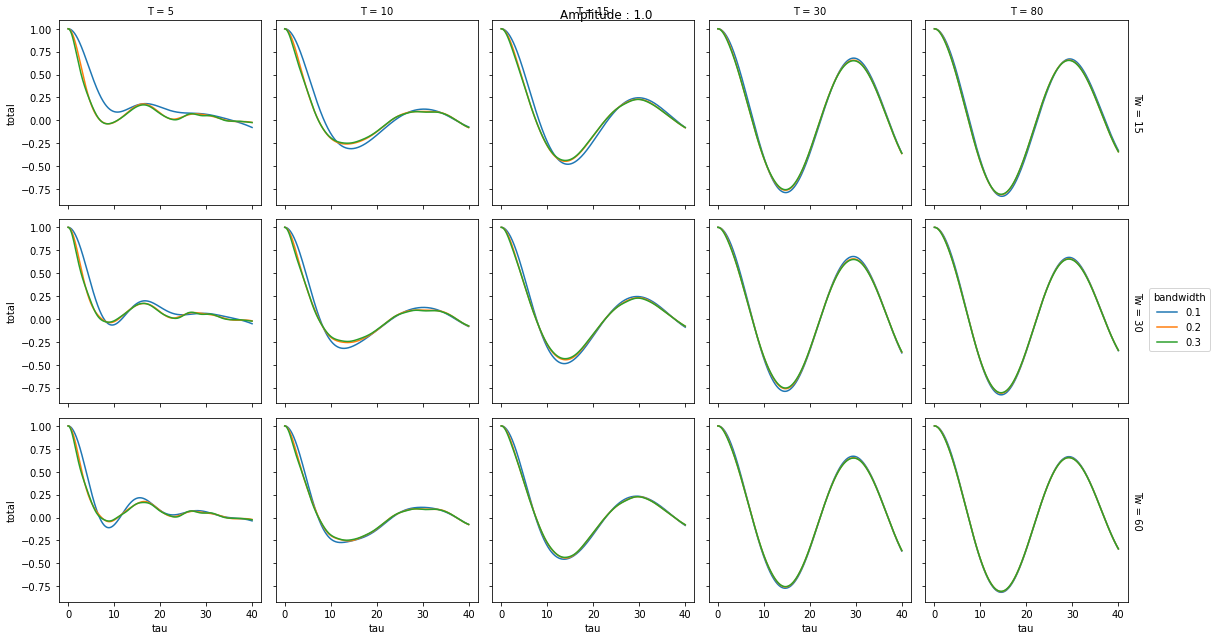

In [65]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

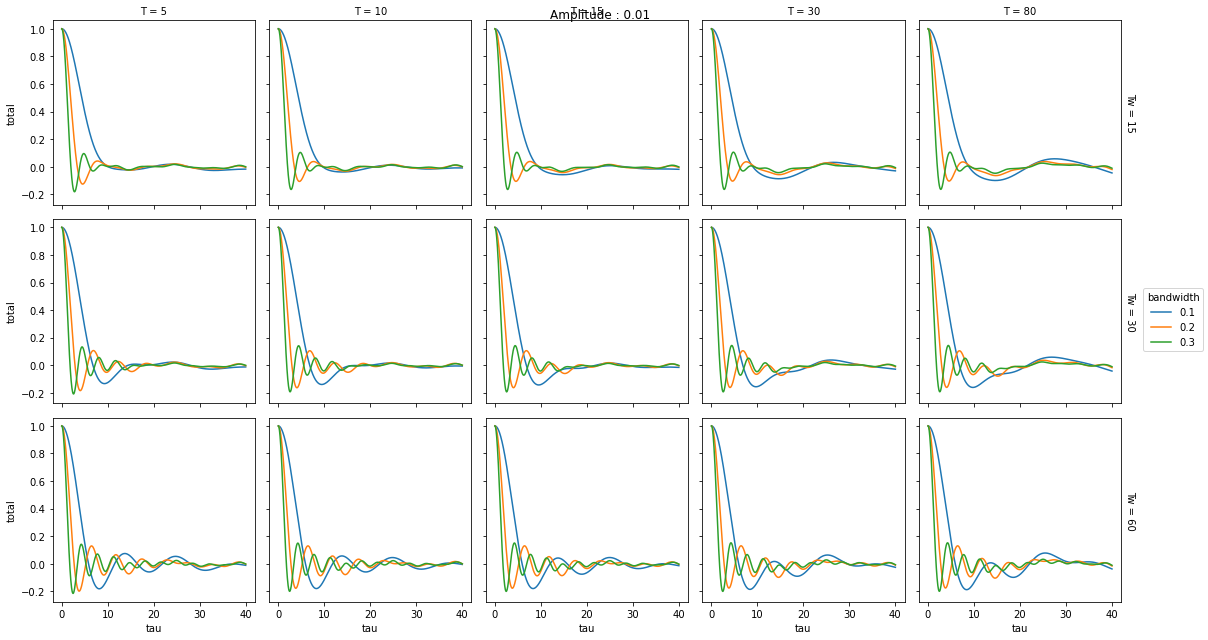

<Figure size 432x288 with 0 Axes>

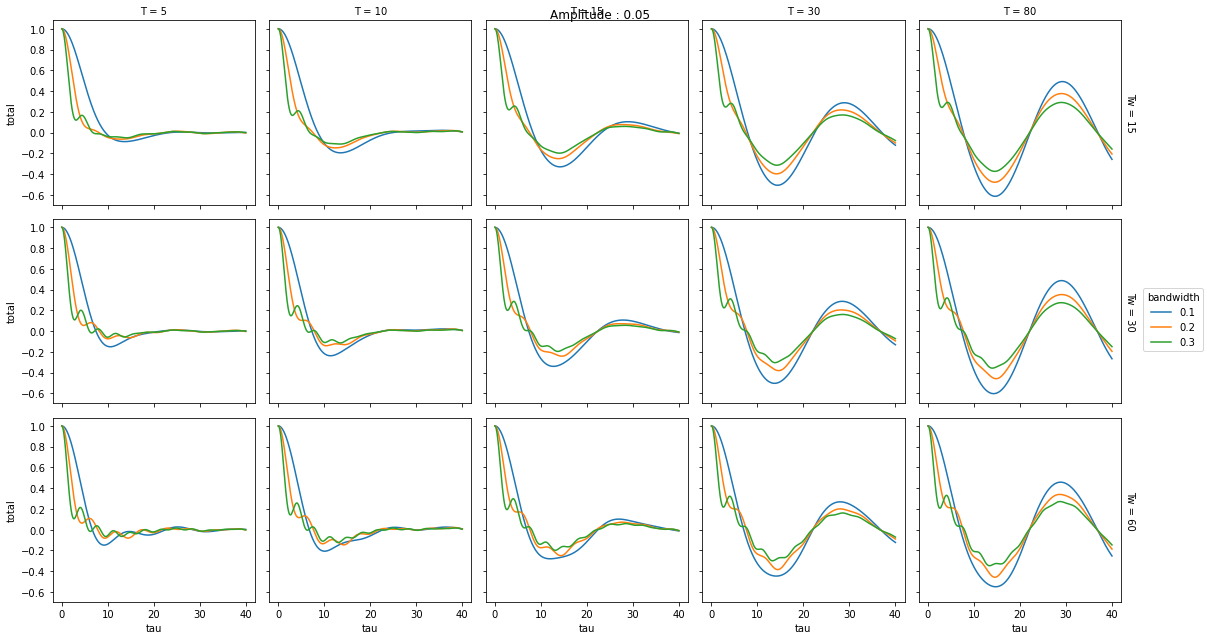

<Figure size 432x288 with 0 Axes>

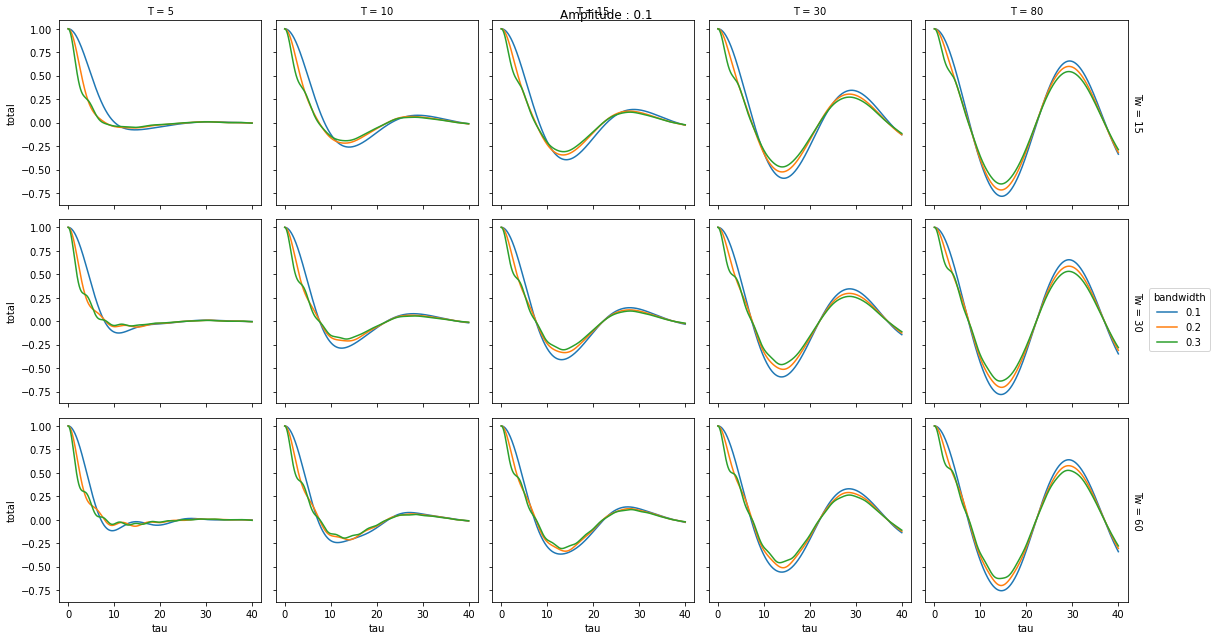

<Figure size 432x288 with 0 Axes>

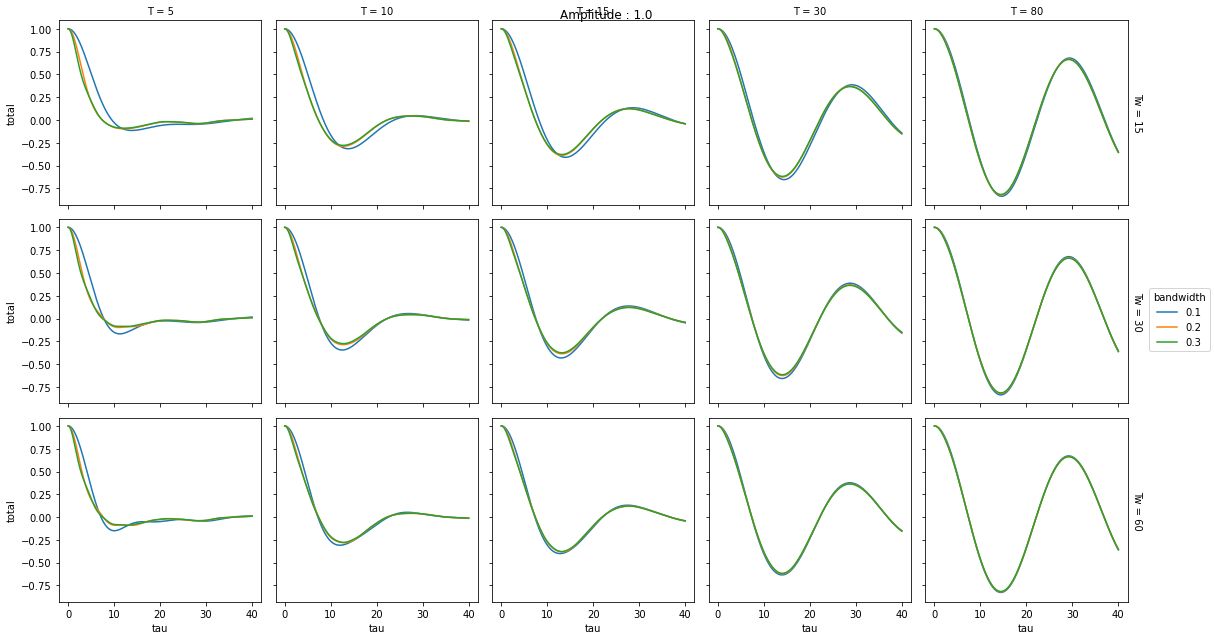

In [20]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=5).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

<Figure size 432x288 with 0 Axes>

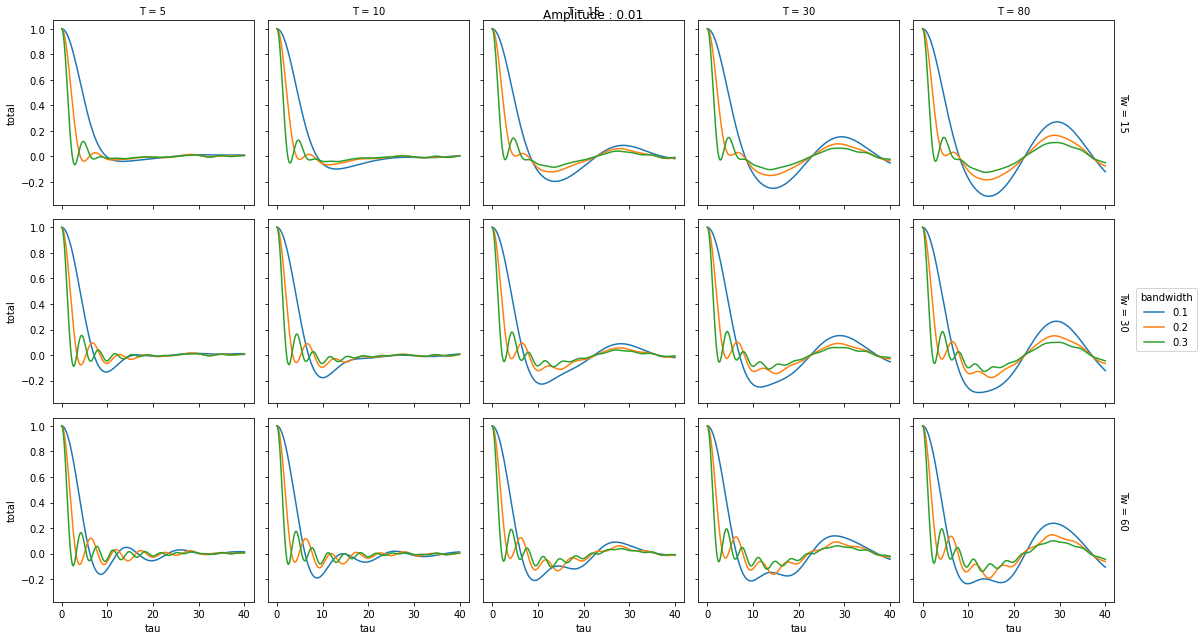

<Figure size 432x288 with 0 Axes>

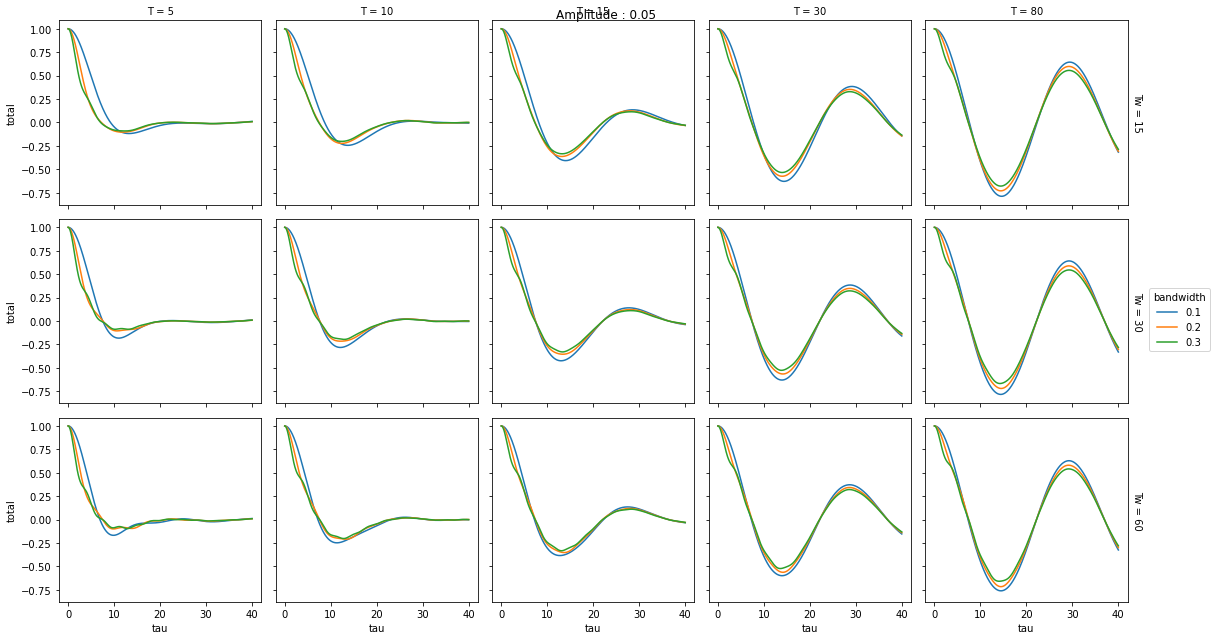

<Figure size 432x288 with 0 Axes>

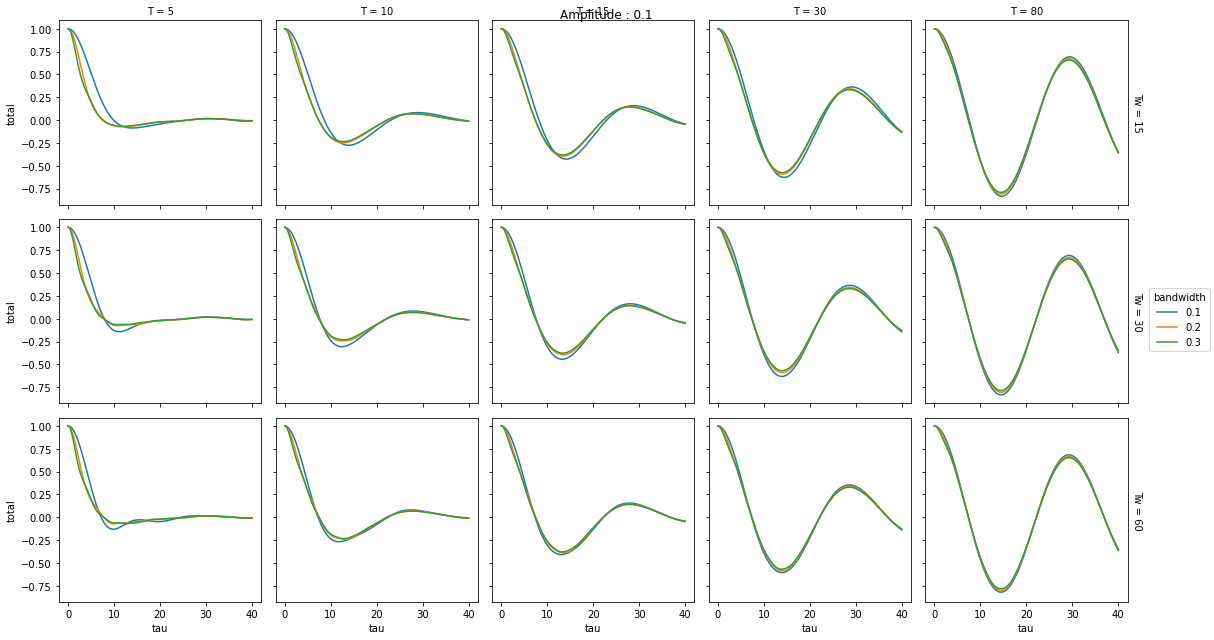

<Figure size 432x288 with 0 Axes>

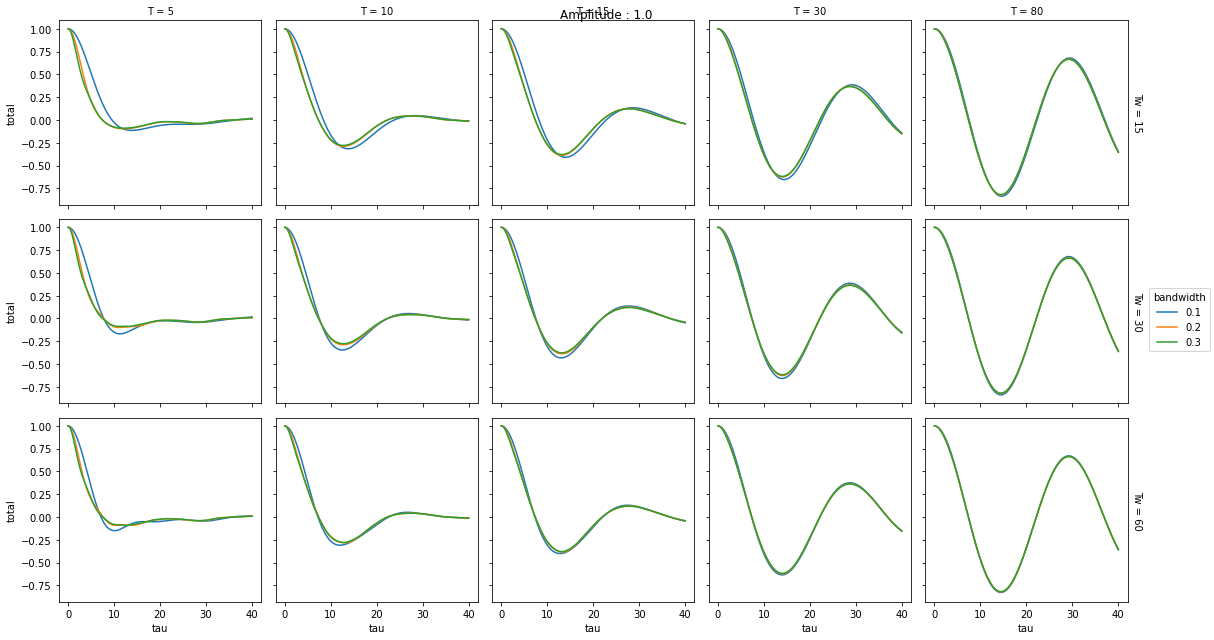

In [21]:
for U in ds1.U_high:
    fig = plt.figure()
    (ds30.total/ds30.total.isel(tau=0)).sel(U_high=U,T_low=30).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()

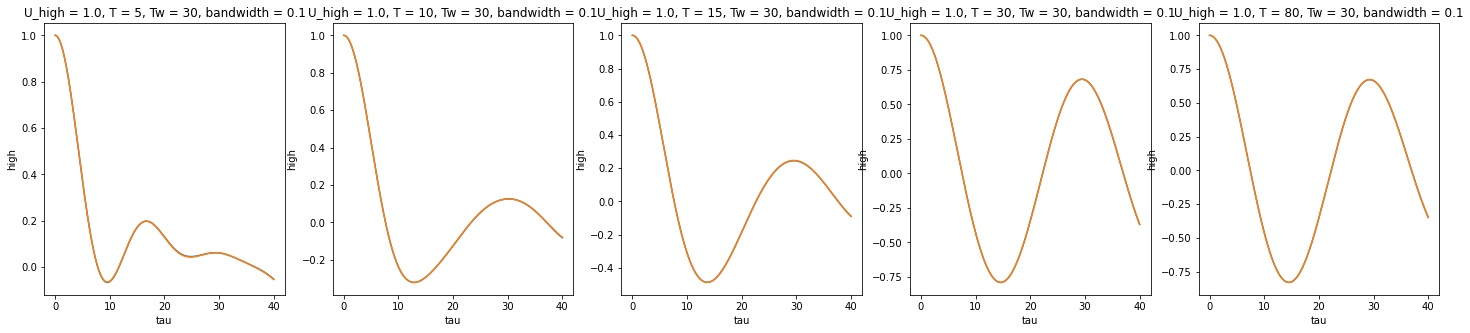

In [32]:
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i,t in enumerate(ds1.T) :
    (ds1.total/ds1.total.isel(tau=0)).sel(U_high=U,T_low=30,Tw=30,bandwidth=0.1,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])
    (ds1.high/ds1.high.isel(tau=0)).sel(U_high=U,Tw=30,bandwidth=0.1,T=t).sel(tau=slice(0,40)).plot(ax=ax[i])